# Analysis of Mental Health in Technology 
#### Kaylynn Crawford 

Visualization (analysis to come) here: https://silentttone.github.io/MentalHealth/

I'm using a dataset about mental health in technology to try to answer the question: what company policies are most effective in encouraging employees to get help for mental health disorders, if necessary? To do this I created a decision tree with "Treatment" as a response variable. 

Currently, I think the results are a bit muddled by variables that are too predictive, such as "Do you currently have a mental disorder." One of my next steps will be picking variables specific to company policy and seeing how useful the resulting tree is. 

### To Do: 
* Filter variables used
* Interpret results

### Current Issues
* Best way to deal with null values (currently: removing them)
* Best way to create treatment variable - should I remove rows with no mental health problems? 
* Does my factorization method create arbitrary ordering? 

### Further steps? 
 * Try this in R and compare results 
 * Remove "too helpful" variables 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

%matplotlib inline

/home/kaylynn/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read in data and correct data types

In [101]:
data = pd.read_csv('../data/mentalHealth.csv')

#Remove columns with an unlimited number of options 
data = data.drop(['Gender', 'CountryLive', 'CountryWork', 'Position'], 1)

colNames = list(data.columns.values)

for n in colNames: 
    if (data[n].dtype == object):
        data[n] = data[n].astype('category')   
        
data.dtypes

SelfEmp                   int64
NumEmp                 category
Tech                    float64
TechRole                float64
Benefits               category
KnowBen                category
DiscussedBen           category
ResourcesBen           category
Anon                   category
MentalLeave            category
DiscMental             category
DiscPhysical           category
DiscMentalCo           category
DiscMentalSup          category
MentalSeriously        category
NegConseq              category
HaveCov                 float64
KnowRes                category
RevDiag                category
NegRevDiag             category
Prod                   category
PrecProd               category
PhyInterview           category
MentalInterview        category
IdentifyMental         category
NegMental              category
FamMental              category
FamHistory             category
PastMental             category
CurMental              category
WhichCondDiag          category
WhichCon

### Deal with NaN Values

Drop the 11 columns with more than 500 no response values in order to get more complete datapoints with the remaining factors

In [102]:
colNames = list(data.columns.values)

for n in colNames:
    if(data[n].isnull().sum() > 500):
        print(n, data[n].isnull().sum())
        data = data.drop([n], axis=1)
        
# data.dtypes

('TechRole', 1170)
('HaveCov', 1146)
('KnowRes', 1146)
('RevDiag', 1146)
('NegRevDiag', 1146)
('Prod', 1146)
('PrecProd', 1229)
('WhichCondDiag', 865)
('WhichCond', 1111)
('StateLive', 592)
('StateWork', 581)
('Unnamed: 44', 1432)


In [103]:
data = data.dropna(axis=0,how='any')

# TODO: Is this the best way to deal with null values? 
# Another option: 
# data['NumEmp'].fillna(-1, inplace=True)

len(data)

data.dtypes

SelfEmp                   int64
NumEmp                 category
Tech                    float64
Benefits               category
KnowBen                category
DiscussedBen           category
ResourcesBen           category
Anon                   category
MentalLeave            category
DiscMental             category
DiscPhysical           category
DiscMentalCo           category
DiscMentalSup          category
MentalSeriously        category
NegConseq              category
PhyInterview           category
MentalInterview        category
IdentifyMental         category
NegMental              category
FamMental              category
FamHistory             category
PastMental             category
CurMental              category
Diagnosed              category
Treatment                 int64
InterfereTreated       category
InterfereNotTreated    category
Age                       int64
Remote                 category
dtype: object

### Prepare variables for model

If person says they do not have a mental disorder, the treatment response variable is set to -1, because it's not applicable. 

Factorize categorical variables. 

In [104]:
# TODO: Figure out if this is the best way to handle this. Other options: remove row? 
# data.ix[data.CurMental == "No", 'Treatment'] = -1

In [105]:
# TODO: This impose arbitrary ordering - how to handle/fix this
# Reference: https://gist.github.com/ramhiser/982ce339d5f8c9a769a0

# factorizedData = pd.DataFrame()

# colNames = list(data.columns.values)

# for n in colNames: 
#     if (str(data[n].dtype) == 'category'):
#         newCat = n + "_enc"
#         catenc = pd.factorize(data[n])
#         factorizedData[newCat] = catenc[0]
#     else:
#         factorizedData[n] = data[n]
        

In [133]:
factorizedData = pd.DataFrame()

colNames = list(data.columns.values)

for n in colNames: 
    if (str(data[n].dtype) == 'category'):
        one_hot = pd.get_dummies(data[n], prefix=n)
        factorizedData = factorizedData.join(one_hot)
        
# factorizedData['Treatment'] = data['Treatment']

# for n in list(factorizedData.columns.values):
#     print n
    

KeyError: 0

### Create training and test set

In [126]:
X = factorizedData.drop(['CurMental_Maybe', 'CurMental_Yes'], axis=1)
y = factorizedData.Treatment
# y = pd.concat([factorizedData['Treatment_-1'],factorizedData['Treatment_0'],factorizedData['Treatment_1']], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

# This is a problem: 
# print(X.isnull().sum())

factorizedData.head(10)

,NumEmp_1-5,NumEmp_100-500,NumEmp_26-100,NumEmp_500-1000,NumEmp_6-25,NumEmp_More than 1000,Benefits_I don't know,Benefits_No,Benefits_Not eligible for coverage / N/A,Benefits_Yes,...,InterfereNotTreated_Never,InterfereNotTreated_Not applicable to me,InterfereNotTreated_Often,InterfereNotTreated_Rarely,InterfereNotTreated_Sometimes,Remote_Always,Remote_Back-end Developer,Remote_Never,Remote_Sometimes,Treatment
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Create decision tree

In [121]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### Visualize tree

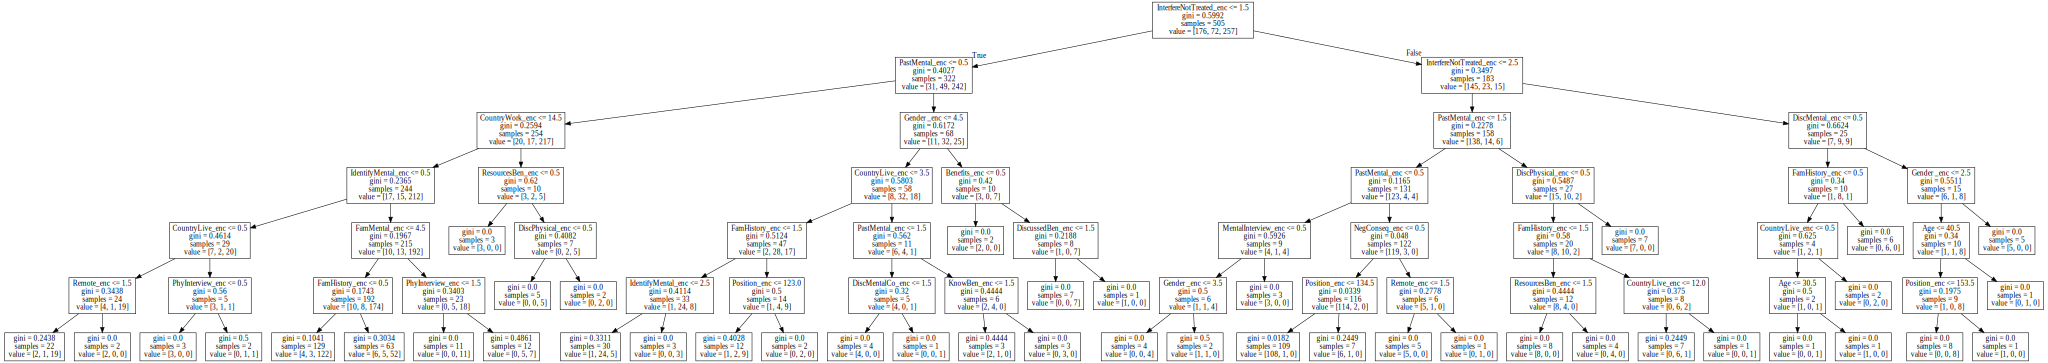

In [53]:
export_graphviz(clf, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)